In [29]:
colab = True
if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    import os
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 1')

# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Estudante:

Base de dados: 

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<h1> Importante! </h1>

1. Fique atento com os hiperparâmetros iniciais desta lista. Dependendo do problema, os valores podem mudar. Para encontrar um conjunto de parâmetros razoáveis, siga o seguinte roteiro: 

        1. Rode os itens 2.1 e 3.1 com os parâmetros iniciais. Se os dois resultados foram igualmente ruins, modifique os parâmetros do item 3.1 até que o resultado seja relativamente melhor que o 2.1.

        2. Após obter esses melhores parâmetros iniciais, rode novamente o item 2.1 com os mesmos hiperparâmetros para uma comparação mais justa. 

2. O resultado de um modelo de Redes Neurais geralmente depende da inicialização de seus pesos. Portanto, para cada questão, obtenha um resultado médio de pelo menos 10 rodadas.

In [64]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import sleep
import requests

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [31]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [73]:
dataset_name = 'analise_credito'
dataset_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [74]:
resp = requests.get(info_path)
info = json.loads(resp.text)

In [75]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [76]:
for i in dataset.dtypes.items():
    print(i)

('ESTC', dtype('O'))
('NDEP', dtype('int64'))
('RENDA', dtype('int64'))
('TIPOR', dtype('O'))
('VBEM', dtype('int64'))
('NPARC', dtype('int64'))
('VPARC', dtype('int64'))
('TEL', dtype('O'))
('IDADE', dtype('int64'))
('RESMS', dtype('int64'))
('ENTRADA', dtype('int64'))
('target', dtype('int64'))


## Parte I - Compreensão do problema e análise de variáveis

Total: 2,0 pts.


### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

#### Resposta

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

#### Resposta

In [38]:
#sns.pairplot(dataset, hue="target", diag_kind="hist")

## Parte II. Treinamento do modelo de Rede Neural - Baseline 

Total: 1,0 pts.

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [39]:
new_df = transform_data(dataset, normalize=False)
#new_df.head()

In [40]:
new_df.head()

,ESTC,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,target
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [41]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [42]:
batch_size = 32 
epochs = 170

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [44]:

#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())



In [45]:
#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [46]:
train_dataset.X_data

tensor([[1.0000e+00, 0.0000e+00, 7.0000e+02,  ..., 5.8000e+01, 6.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.4600e+02,  ..., 4.0000e+01, 6.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.7800e+02,  ..., 2.7000e+01, 6.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 5.3000e+02,  ..., 6.3000e+01, 0.0000e+00,
         2.8500e+02],
        [1.0000e+00, 0.0000e+00, 7.5700e+02,  ..., 2.0000e+01, 4.8000e+01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+03,  ..., 3.6000e+01, 6.0000e+00,
         0.0000e+00]])

In [47]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [48]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 6.590 | Val Loss: 0.6991 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 002: | Train Loss: 0.702 | Val Loss: 0.6980 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 003: | Train Loss: 0.700 | Val Loss: 0.6971 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 004: | Train Loss: 0.699 | Val Loss: 0.6964 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 005: | Train Loss: 0.698 | Val Loss: 0.6957 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 006: | Train Loss: 0.698 | Val Loss: 0.6952 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 007: | Train Loss: 0.697 | Val Loss: 0.6948 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 008: | Train Loss: 0.696 | Val Loss: 0.6944 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 009: | Train Loss: 0.696 | Val Loss: 0.6941 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 010: | Train Loss: 0.695 | Val Loss: 0.6939 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 011: | Train Loss: 0.695 | Val Loss: 0.6937 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 012: | Train Lo

In [49]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       164
           1       0.00      0.00      0.00       136

    accuracy                           0.55       300
   macro avg       0.27      0.50      0.35       300
weighted avg       0.30      0.55      0.39       300



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


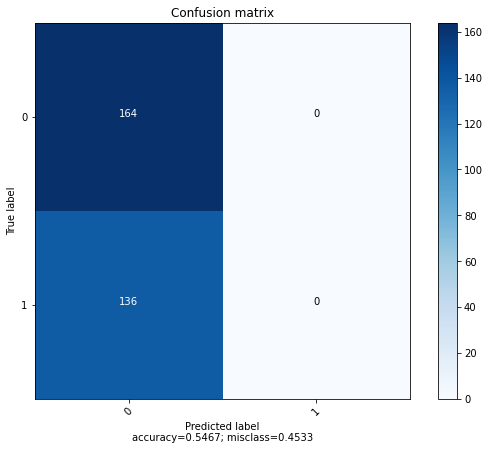

In [50]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

## Parte III - Mudança de configurações do modelo

Total: 5,0 pts.

### 1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [ ]:
new_df = transform_data(dataset, normalize=True)
new_df.head()

,ESTC,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,target
0,0.333333,0.0,0.007792,0.0,0.003514,0.347826,0.003026,0.0,0.117647,0.114286,0.0,1
1,0.000000,0.0,0.006494,1.0,0.045405,0.391304,0.022693,0.0,0.274510,0.014286,0.0,1
2,0.000000,0.0,0.103896,0.0,0.142973,0.347826,0.113464,0.0,0.725490,0.114286,0.0,1
3,0.000000,0.0,0.350649,0.0,0.068108,0.478261,0.039334,1.0,0.235294,0.142857,0.0,1
4,0.333333,0.0,0.090909,0.0,0.137568,0.478261,0.092284,0.0,0.098039,0.016667,0.0,1


In [ ]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [ ]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.684 | Val Loss: 0.6824 | Train Acc: 62.4667| Val Acc: 63.0000
Epoch 002: | Train Loss: 0.681 | Val Loss: 0.6798 | Train Acc: 64.2667| Val Acc: 64.0000
Epoch 003: | Train Loss: 0.678 | Val Loss: 0.6774 | Train Acc: 65.4333| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.675 | Val Loss: 0.6753 | Train Acc: 66.0000| Val Acc: 64.0000
Epoch 005: | Train Loss: 0.673 | Val Loss: 0.6733 | Train Acc: 65.7667| Val Acc: 64.0000
Epoch 006: | Train Loss: 0.670 | Val Loss: 0.6713 | Train Acc: 65.6000| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.668 | Val Loss: 0.6694 | Train Acc: 65.6333| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.666 | Val Loss: 0.6674 | Train Acc: 66.2667| Val Acc: 66.0000
Epoch 009: | Train Loss: 0.663 | Val Loss: 0.6653 | Train Acc: 66.2667| Val Acc: 66.0000
Epoch 010: | Train Loss: 0.661 | Val Loss: 0.6632 | Train Acc: 66.3667| Val Acc: 67.0000
Epoch 011: | Train Loss: 0.658 | Val Loss: 0.6610 | Train Acc: 66.6000| Val Acc: 68.0000
Epoch 012: | Train Lo

#### Resposta

In [ ]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       0.86      0.97      0.91       164
           1       0.96      0.82      0.88       136

    accuracy                           0.90       300
   macro avg       0.91      0.89      0.90       300
weighted avg       0.91      0.90      0.90       300



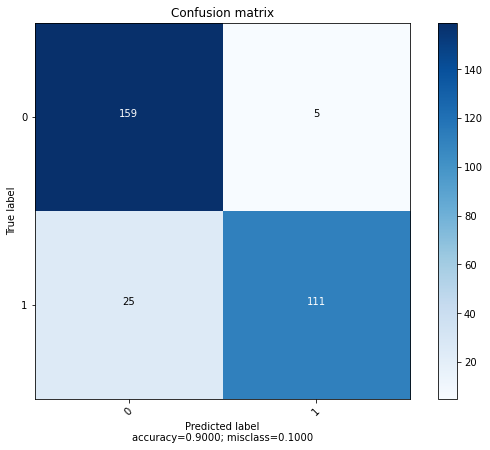

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

#### Resposta

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

#### Resposta

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

#### Resposta

## Parte IV - Usando outras técnicas para Redes Neurais 
Total: 3,0 pts.

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: para essa questão, copie a função `train` do arquivo `model_utils.py`, copie neste notebook e faça as adaptações necessárias.

#### Rascunho

#### Resposta

### 2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

#### Rascunho

#### Resposta

### 3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

#### Resposta